# **Grupo Bimbo Inventory Demand**

#
Copyright [2021] [Vachana Belgavi]

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
#

# Abstract

The purpose of the data analytics project is to predict the demand for a product for a given week at a particular store for the Grupo Bimbo Inventory. The dataset is taken from the Kaggle contest. Python language is used with
Google Colab. The different data mining concepts used in the pre-preprocessing, data concatenation and data transformation of the data. Data visualization is done with the heatmap and bar graphs. Decision Tree feature selection is performed on the dataset to check which features will give the best results. Trained models using Ridge regression, Lasso regression, Elastic-Net and Robust linear model estimation using RANSAC algorithm. Finally, post-processed the train and and test dataset.

IMPORTING ALL THE NECESSARY LIBRARIES.

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
%pylab inline
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


READING ALL THE DATA FILES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
import io
uploaded = files.upload

client = pd.read_csv("/content/drive/MyDrive/grupo-bimbo-inventory-demand/cliente_tabla.csv")
product = pd.read_csv("/content/drive/MyDrive/grupo-bimbo-inventory-demand/producto_tabla.csv")
town = pd.read_csv("/content/drive/MyDrive/grupo-bimbo-inventory-demand/town_state.csv")
#train = pd.read_csv("/content/drive/MyDrive/grupo-bimbo-inventory-demand/train.csv")
test = pd.read_csv("/content/drive/MyDrive/grupo-bimbo-inventory-demand/test.csv")

RENAMING THE COLUMNS

In [ ]:
client.columns = ['Client_ID', 'name']
product.columns = ['Product_ID', 'Product_Name']
town.columns = ['Sales_Depot_ID', 'Town_name', 'State_name']
#train.columns = ['Week_number', 'Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID',\
                #'Sales_unit_this_week', 'Sales_this_week', 'Returns_unit_this_week', 'Returns_this_week',\
                #'Adjusted_Demand']
test.columns = ['ID', 'Week_number', 'Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID']

PREPROCESSING CLIENT DATA

In [ ]:
client.isnull().values.any()

False

In [ ]:
print("Before dropping the duplicate rows ",client.shape)
client.drop_duplicates(['Client_ID'],keep='first',inplace=True)
print("After dropping the duplicate rows ",client.shape)

Before dropping the duplicate rows  (935362, 2)
After dropping the duplicate rows  (930500, 2)


In the client table, some of the names are as follows:<br>
'NO IDENTIFICADO','SIN NOMBRE'<br>
Replacing such names with NO_Name

In [ ]:
client.loc[(client['name'] == 'NO IDENTIFICADO') | (client['name'] == 'SIN NOMBRE') |
           (client['name'] == 'INACTIVAR NO TOCAR') ,'name' ] = 'NO_Name'

Column Transformation

For label encoding, referred https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

client['Client_name']= client['name']
client['Client_name'] = le.fit_transform(client['Client_name'])
client.head()

,Client_ID,name,Client_name
0,0,NO_Name,228431
1,1,OXXO XINANTECATL,238101
2,2,NO_Name,228431
3,3,EL MORENO,90955
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT,270834


PREPROCESSING TOWN_STATE DATA

In [ ]:
town.isnull().values.any()

False

Checking for duplicates

In [ ]:
print("Before dropping the duplicates", town.shape)
town.drop_duplicates(['Sales_Depot_ID'],keep='first',inplace=True)
print("After dropping the duplicates", town.shape)

Before dropping the duplicates (790, 3)
After dropping the duplicates (790, 3)


Using regular expressions to format text in the town_state dataset<br>
1. Replacing spaces with underscores<br>
2. Replacing non-alphabetic values

In [ ]:
print("Before formatting\n")
print(town.head())
town['Town_name'] = town['Town_name'].str.replace('^([^\s]+)\s', '')
town['Town_name'] = town['Town_name'].str.replace('\d+', '')
town['Town_name'] = town['Town_name'].str.replace('.','')
town['Town_name'] = town['Town_name'].str.replace(' ','_')
town['Town_name'] = town['Town_name'].str.replace('Ã\s*','AN')
town['State_name'] = town['State_name'].str.replace(',','')
town['State_name'] = town['State_name'].str.replace('.','')
town['State_name'] = town['State_name'].str.replace(' ','_')
print("\nAfter formatting")
town.head()

Before formatting

   Sales_Depot_ID              Town_name        State_name
0            1110     2008 AG. LAGO FILT      MÉXICO, D.F.
1            1111  2002 AG. AZCAPOTZALCO      MÉXICO, D.F.
2            1112    2004 AG. CUAUTITLAN  ESTADO DE MÉXICO
3            1113     2008 AG. LAGO FILT      MÉXICO, D.F.
4            1114   2029 AG.IZTAPALAPA 2      MÉXICO, D.F.

After formatting


,Sales_Depot_ID,Town_name,State_name
0,1110,AG_LAGO_FILT,MÉXICO_DF
1,1111,AG_AZCAPOTZALCO,MÉXICO_DF
2,1112,AG_CUAUTITLAN,ESTADO_DE_MÉXICO
3,1113,AG_LAGO_FILT,MÉXICO_DF
4,1114,AGIZTAPALAPA_,MÉXICO_DF


Column transformations

In [ ]:
town['Town']= town['Town_name']
town['Town'] = le.fit_transform(town['Town'])
town['State'] = town['State_name']
town['State'] = le.fit_transform(town['State'])
town.head()

,Sales_Depot_ID,Town_name,State_name,Town,State
0,1110,AG_LAGO_FILT,MÉXICO_DF,25,16
1,1111,AG_AZCAPOTZALCO,MÉXICO_DF,17,16
2,1112,AG_CUAUTITLAN,ESTADO_DE_MÉXICO,22,9
3,1113,AG_LAGO_FILT,MÉXICO_DF,25,16
4,1114,AGIZTAPALAPA_,MÉXICO_DF,9,16


PREPROCESSING PRODUCT DATA

In [ ]:
product.isnull().values.any()

False

Dropping the duplicate values

In [ ]:
print("Before dropping the duplicates", product.shape)
product.drop_duplicates(['Product_ID'],keep='first',inplace=True)
print("After dropping the duplicates", product.shape)

Before dropping the duplicates (2592, 2)
After dropping the duplicates (2592, 2)


In the product dataset, name is combined with a lot of other information like weights and number of pieces.<br>
Extracting all the values to different columns correctly.<br>
Using regular expressions to separate the values<br>
Separating the name, number of pieces and the weights of each item.

Referred https://www.kaggle.com/lyytinen/basic-preprocessing-for-products for formatting the Product Name.

In [ ]:
print("BEFORE\n")
print(product.head())

id_list = product['Product_ID'].values
name_list = product['Product_Name'].values
num_product = name_list.shape[0]

product_weight_list = np.empty(num_product)
product_weight_list[:] = np.NAN
product_piece_list = np.ones(num_product)
product_brand_list = list()
product_short_name_list = list()

product_info_list = zip(id_list,name_list)

#extract weight,piece,brand and prod_name

regex_piece_weight = re.compile(r'(.*?)(\d+)(p|P).*?(\d+)\s*(kg|Kg|g|G|ml)') #check for line with piece first and then weight
regex_weight_piece = re.compile(r'(.*?)(\d+)\s*(kg|Kg|g|G|ml).*?(\d+)(p|P)') #opp of first
regex_weight = re.compile(r'(.*?)(\d+)\s*(kg|Kg|g|G|ml)')  #line with only weights
regex_piece = re.compile(r'(.*?)(\d+)(p|P)(?!ct|CT)')  #line with only piece

dont_know_list = ['MTB', 'MTA', 'TNB', 'CU', 'TAB']

for i, (product_id, orig_product_name) in enumerate(product_info_list):
    product_name = orig_product_name.rstrip(str(product_id)).strip()
    
    product_name_words = product_name.split()   
    
    if re.search(regex_piece_weight, product_name):
        regex_result = re.search(regex_piece_weight, product_name)
        product_weight_list[i] = float(regex_result.group(4))
        product_piece_list[i] = int(regex_result.group(2))
        product_short_name = regex_result.group(1)
        if regex_result.group(5) == 'kg' or regex_result.group(5) == 'Kg':       #replace kg values with gram
            product_weight_list[i] *= 1000
            
    elif re.search(regex_weight_piece, product_name):
        regex_result = re.search(regex_weight_piece, product_name)
        product_weight_list[i] = float(regex_result.group(2))
        product_piece_list[i] = int(regex_result.group(4))
        if regex_result.group(3) == 'kg' or regex_result.group(3) == 'Kg': 
            product_weight_list[i] *= 1000
        product_short_name = regex_result.group(1)
        
    elif re.search(regex_weight, product_name):
        regex_result = re.search(regex_weight, product_name)
        product_weight_list[i] = float(regex_result.group(2))
        if regex_result.group(3) == 'kg' or regex_result.group(3) == 'Kg':
            product_weight_list[i] *= 1000
        product_short_name = regex_result.group(1)
        
    elif re.search(regex_piece, product_name):
        regex_result = re.search(regex_piece, product_name)
        product_piece_list[i] = int(regex_result.group(2))
        product_short_name = regex_result.group(1) 
        
        #After separating out values ,still there are some values attached with product name.Remove them
    else:
        product_short_name = ' '.join([word for word in product_name_words[:-1] if word not in dont_know_list])
        
    product_brand_list.append(product_name_words[-1])
    product_short_name_list.append(product_short_name)
    
product['product'] = product_short_name_list
product['brand'] = product_brand_list
product['weight'] = product_weight_list
product['pieces'] = product_piece_list

product.drop('Product_Name',axis = 1,inplace=True)
print("\nAFTER")
product.head()

BEFORE

   Product_ID                            Product_Name
0           0                       NO IDENTIFICADO 0
1           9               Capuccino Moka 750g NES 9
2          41  Bimbollos Ext sAjonjoli 6p 480g BIM 41
3          53          Burritos Sincro 170g CU LON 53
4          72     Div Tira Mini Doradita 4p 45g TR 72

AFTER


,Product_ID,product,brand,weight,pieces
0,0,NO,IDENTIFICADO,NaN,1.0
1,9,Capuccino Moka,NES,750.0,1.0
2,41,Bimbollos Ext sAjonjoli,BIM,480.0,6.0
3,53,Burritos Sincro,LON,170.0,1.0
4,72,Div Tira Mini Doradita,TR,45.0,4.0


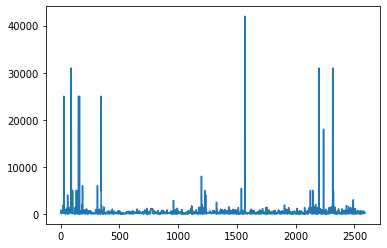

,weight,pieces
count,2541.000000,2592.000000
mean,413.480913,6.520448
std,1764.304179,13.941169
min,4.000000,0.000000
25%,80.000000,1.000000
50%,180.000000,1.000000
75%,400.000000,8.000000
max,42000.000000,200.000000


In [ ]:
product['weight'].plot()
plt.show()
P = product[['weight','pieces']]
P.describe()

We can infer from the above graph that many of the weights are below 10000 and only a few tuples are above that range.<br>
Replacing 'NaN' values with the mean will not be a feasible solution. Hence, replaced those values with median.<br>
Replacing 0 with 1 making it minimum for one piece.


In [ ]:
product['weight'].fillna(180,inplace=True)
product.loc[product['pieces']==0.0,'pieces']=1.0
product.head()

,Product_ID,product,brand,weight,pieces
0,0,NO,IDENTIFICADO,180.0,1.0
1,9,Capuccino Moka,NES,750.0,1.0
2,41,Bimbollos Ext sAjonjoli,BIM,480.0,6.0
3,53,Burritos Sincro,LON,170.0,1.0
4,72,Div Tira Mini Doradita,TR,45.0,4.0


In [ ]:
P = product[['weight','pieces']]
P.describe()

,weight,pieces
count,2592.000000,2592.000000
mean,408.886960,6.523920
std,1747.155083,13.939669
min,4.000000,1.000000
25%,80.000000,1.000000
50%,180.000000,1.000000
75%,400.000000,8.000000
max,42000.000000,200.000000


Transformation of Product_name

For transformation, used label encoder because data set consists of many unique nominal values. Label encoder helps
use those values in equations as numeric, which makes the prediction easier.


In [ ]:
product['product_name']= product['product']
product['product_name'] = le.fit_transform(product['product_name'])
product.head()

,Product_ID,product,brand,weight,pieces,product_name
0,0,NO,IDENTIFICADO,180.0,1.0,568
1,9,Capuccino Moka,NES,750.0,1.0,203
2,41,Bimbollos Ext sAjonjoli,BIM,480.0,6.0,79
3,53,Burritos Sincro,LON,170.0,1.0,175
4,72,Div Tira Mini Doradita,TR,45.0,4.0,277


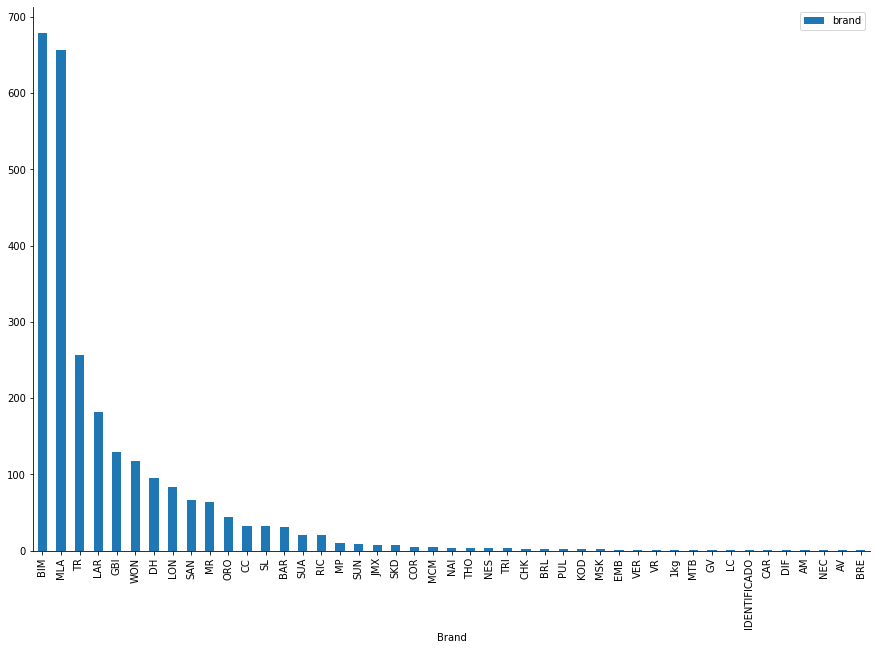

In [ ]:
df=product['brand'].value_counts()
df.plot(kind='bar', legend=True,figsize=(15,10))
plt.xlabel('Brand')
sns.despine()

According to the above graph, two brands are very popular from the rest of them. Famous brands in Mexico are 'BIM'- Bimbo and 'MLA'- Marinela.

## Preprocessing training data

AS THE TRAIN DATASET IS TOO LARGE, READING IT IN ITERATIONS.

The train dataset has 11 columns which are Week_number, Sales_Depot_ID, Sales_Channel_ID, Route_ID, Client_ID, Product_ID, Sales_unit_this_week, Sales_this_week, Returns_unit_next_week, Returns_next_week, Adjusted_Demand.

In the below function, the dataset is read in chunks and the duplicates are discarded in the process.


Referred https://www.shanelynn.ie/python-pandas-read-csv-load-data-from-csv-files/ for reading datasets.

In [ ]:
def ReadTrain(df):
    s=0
    n=10000000
    for x in range(7):
        if x == 0:
            print('Reading ',s,' to ',n+s)
            train1 = pd.read_csv('/content/drive/MyDrive/grupo-bimbo-inventory-demand/train.csv',nrows=n,header = 0,index_col=None,usecols=[0,1,2,3,4,5,6,7,8,9,10],
                    dtype={'Semana':np.uint8,'Agencia_ID':np.uint16,'Canal_ID':np.uint16,'Ruta_SAK':np.uint16,\
                           'Cliente_ID':np.uint16,'Producto_ID':np.uint16,'Venta_uni_hoy':np.uint16,'Venta_hoy':np.float32,\
                           'Dev_uni_proxima':np.uint16,'Dev_proxima':np.float32,'Demanda_uni_equil':np.uint16})

            train1.columns = ['Week_number', 'Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID',\
                              'Sales_unit_this_week', 'Sales_this_week', 'Returns_unit_next_week', 'Returns_next_week',\
                              'Adjusted_Demand']                                             ##rename columns of train dataset
            train1.head()
        elif x < 6:
            print('Reading ',s,' to ',n+s)
            train1 = pd.read_csv('/content/drive/MyDrive/grupo-bimbo-inventory-demand/train.csv',skiprows=range(1,s+1),nrows=n,header = 0,index_col=None,usecols=[0,1,2,3,4,5,6,7,8,9,10],
                    dtype={'Semana':np.uint8,'Agencia_ID':np.uint16,'Canal_ID':np.uint16,'Ruta_SAK':np.uint16,\
                           'Cliente_ID':np.uint16,'Producto_ID':np.uint16,'Venta_uni_hoy':np.uint16,'Venta_hoy':np.float32,\
                           'Dev_uni_proxima':np.uint16,'Dev_proxima':np.float32,'Demanda_uni_equil':np.uint16})

            train1.columns = ['Week_number', 'Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID',\
                              'Sales_unit_this_week', 'Sales_this_week', 'Returns_unit_next_week', 'Returns_next_week',\
                              'Adjusted_Demand']
            train1.head()
        else:
            print('Reading remaining values')
            train1 = pd.read_csv('/content/drive/MyDrive/grupo-bimbo-inventory-demand/train.csv',skiprows=range(1,s+1),header = 0,index_col=None,usecols=[0,1,2,3,4,5,6,7,8,9,10],
                    dtype={'Semana':np.uint8,'Agencia_ID':np.uint16,'Canal_ID':np.uint16,'Ruta_SAK':np.uint16,\
                           'Cliente_ID':np.uint16,'Producto_ID':np.uint16,'Venta_uni_hoy':np.uint16,'Venta_hoy':np.float32,\
                           'Dev_uni_proxima':np.uint16,'Dev_proxima':np.float32,'Demanda_uni_equil':np.uint16})

            train1.columns = ['Week_number', 'Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID', 'Product_ID',\
                              'Sales_unit_this_week', 'Sales_this_week', 'Returns_unit_next_week', 'Returns_next_week',\
                              'Adjusted_Demand']

            train1.head()
        s=s+n
        print('Checking for null values')
        print('Number before droping Nan values:',train1.shape[0])
        train1.dropna(axis=0,how='any',subset=['Week_number','Sales_Depot_ID','Client_ID','Product_ID'])
        print('Number after droping Nan values:',train1.shape[0])
        
        print('Checking for duplicate values')
        print('Number before droping duplicate values:',train1.shape[0])
        orginal = train1.shape[0]
        train1.drop_duplicates(subset=['Week_number','Sales_Depot_ID','Client_ID','Product_ID','Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand'],keep='first', inplace=True)
        print('Number after droping duplicate values:',train1.shape[0])
        duplicate = orginal-train1.shape[0]
        percentage = (duplicate/orginal)*100
        print("Duplicate values percentage: %.3f%%" % percentage)
        
        print('Number values where returns are more than sales:',train1.loc[train1['Returns_unit_next_week'] > train1['Sales_unit_this_week']].shape[0])
        train1.loc[train1['Returns_unit_next_week'] > train1['Sales_unit_this_week'],['Sales_unit_this_week', 'Returns_unit_next_week']]= \
        train1.loc[train1['Returns_unit_next_week'] > train1['Sales_unit_this_week'],['Returns_unit_next_week','Sales_unit_this_week']].values

        print('Number values where adjusted values are zero:',train1['Adjusted_Demand'].loc[train1['Adjusted_Demand'] ==0].count())
        train1['Diff']=train1['Sales_unit_this_week']-train1['Returns_unit_next_week']
        train1.loc[(train1['Adjusted_Demand'] == 0) & (train1['Sales_unit_this_week'] != train1['Returns_unit_next_week']),['Adjusted_Demand','Diff']] = \
        train1.loc[(train1['Adjusted_Demand'] == 0) & (train1['Sales_unit_this_week'] != train1['Returns_unit_next_week']),['Diff','Adjusted_Demand']].values
        train1.drop(['Diff'],axis=1,inplace=True)
        
        print('Joining all the dataset')
        print('Joining client dataset')
        train1 =pd.merge(train1,client,how='inner',on='Client_ID')
        train1.drop(['Client_ID','name'],axis=1,inplace=True)
        print('Joining Town-state dataset')
        train1 =pd.merge(train1,town,how='inner',on='Sales_Depot_ID')
        train1.drop(['State_name', 'Town_name'],axis=1,inplace=True)
        print('Joining Product dataset')
        train1 =pd.merge(train1,product,how='inner',on='Product_ID') 
        train1.drop(['Product_ID','brand','weight','pieces', 'product'],axis=1,inplace=True)
        
        if x == 0:
            df = train1
        else:
            df = pd.concat((df,train1), axis=0,ignore_index=True)
        print('Shape: ',df.shape,'\n')
    return df

In [ ]:
df = pd.DataFrame(columns=['Week_number', 'Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_name', 'product_name',\
                              'Sales_unit_this_week', 'Sales_this_week', 'Returns_unit_next_week', 'Returns_next_week',\
                              'Adjusted_Demand'])

print('Reading Training data')
df = ReadTrain(df)
print('Completed Reading Training data')
df.head()

Reading Training data
Reading  0  to  10000000
Checking for null values
Number before droping Nan values: 10000000
Number after droping Nan values: 10000000
Checking for duplicate values
Number before droping duplicate values: 10000000
Number after droping duplicate values: 9988110
Duplicate values percentage: 0.119%
Number values where returns are more than sales: 75185
Number values where adjusted values are zero: 163152
Joining all the dataset
Joining client dataset
Joining Town-state dataset
Joining Product dataset
Shape:  (4112439, 13) 

Reading  10000000  to  20000000
Checking for null values
Number before droping Nan values: 10000000
Number after droping Nan values: 10000000
Checking for duplicate values
Number before droping duplicate values: 10000000
Number after droping duplicate values: 9988876
Duplicate values percentage: 0.111%
Number values where returns are more than sales: 75455
Number values where adjusted values are zero: 162506
Joining all the dataset
Joining client 

,Week_number,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Sales_unit_this_week,Sales_this_week,Returns_unit_next_week,Returns_next_week,Adjusted_Demand,Client_name,Town,State,product_name
0,3,1110,7,3301,3.0,25.139999,0.0,0.0,3.0,250299,25,16,758
1,3,1110,7,3301,2.0,16.760000,0.0,0.0,2.0,292487,25,16,758
2,3,1110,7,3301,2.0,16.760000,0.0,0.0,2.0,100282,25,16,758
3,3,1110,7,3301,4.0,33.520000,0.0,0.0,4.0,1089,25,16,758
4,3,1110,7,3301,1.0,8.380000,0.0,0.0,1.0,82835,25,16,758


For pyplots, referred Nikbearbrown's colabs https://colab.research.google.com/drive/1xFqXOc2eJT78HcVDmoD0twNETiTSvUwB?usp=sharing#scrollTo=I8jCKSlLC-dO 

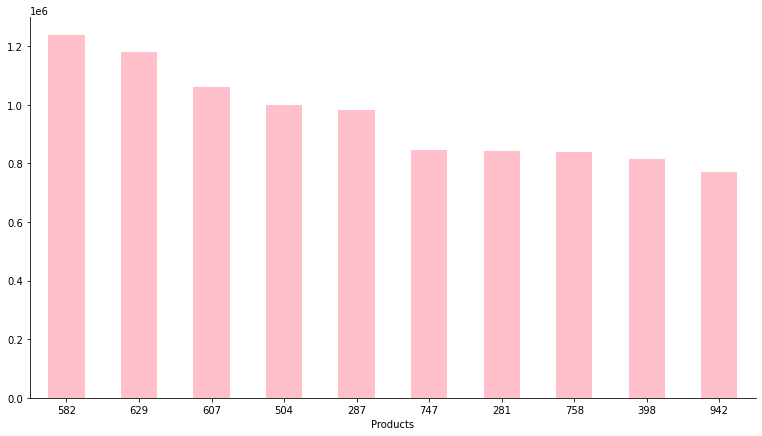

In [ ]:
## TOP 10 BEST SELLING PRODUCTS
t = df[['product_name']]
t = t.product_name.value_counts(sort=True)
t.head(10).plot(kind='bar', color='pink', rot=0,figsize=(13,7))
plt.xlabel('Products')
sns.despine()
del t

The above graph shows the best selling products. We observe that 'nito' product is sold the most.

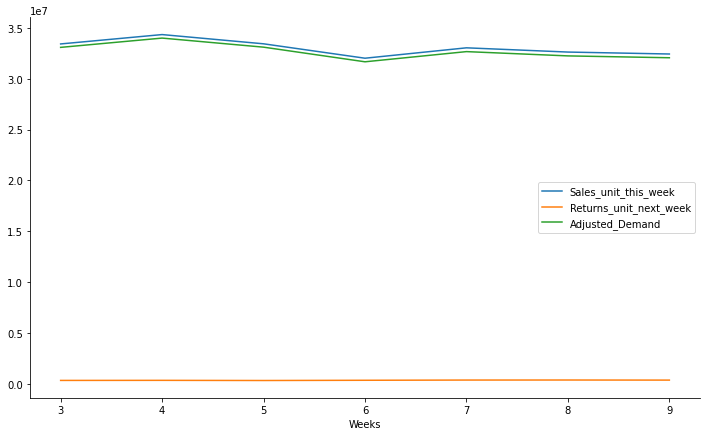

In [ ]:
subset = df[['Week_number','Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand']]
x =subset.groupby(['Week_number']).sum()
x.plot(kind='line', legend=True,figsize=(12,7))
plt.xlabel('Weeks')
sns.despine()

The above graph shows the relationship between the independent and the dependent features.

Also shows that the Sales_unit_this_week and Adjusted_Demand are highly correlated and the Returns_unit_next_week are not so correlated.

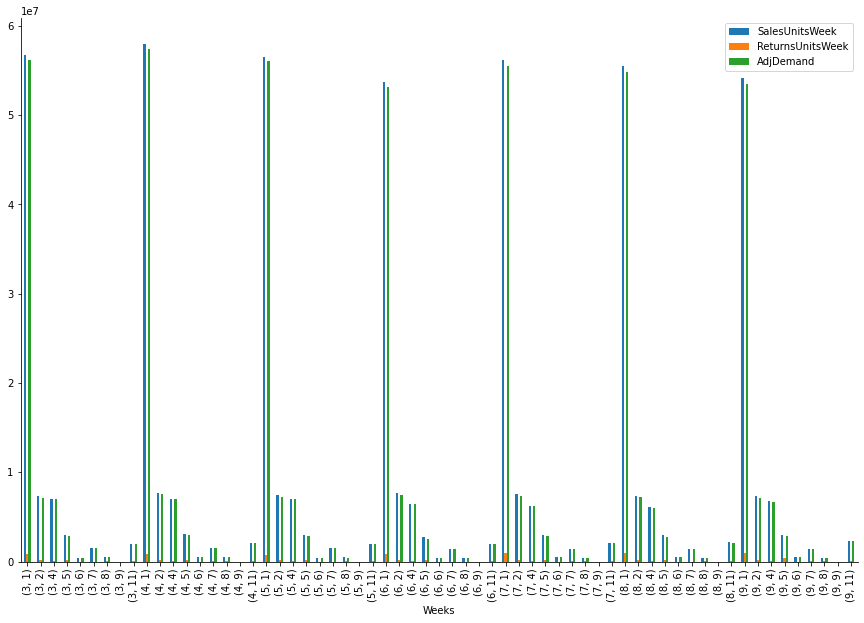

In [ ]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/grupo-bimbo-inventory-demand/train.csv',usecols=[0,2,6,8,10],dtype={'Semana':int,'Canal_ID':int,'Venta_uni_hoy':int,'Dev_uni_proxima':int,'Demanda_uni_equil':int})
df_train.columns =['WeekNum','ChannelId','SalesUnitsWeek','ReturnsUnitsWeek','AdjDemand']
y=df_train.groupby(['WeekNum','ChannelId']).sum()
y.plot(kind='bar', legend=True,figsize=(15,10))
plt.xlabel('Weeks')
sns.despine()
del df_train

This graph shows distribution of products week-wise through channels and we observe that channel 1 has the most distributions among all the others.

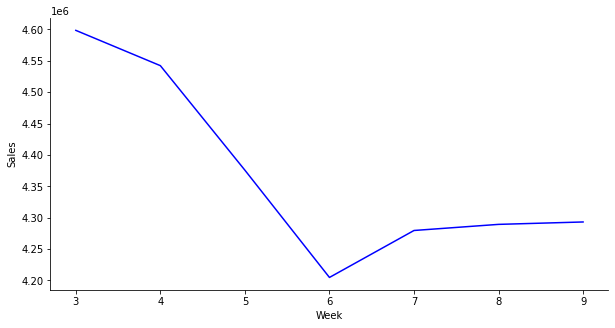

In [ ]:
t = df[['Week_number']]
t.Week_number.value_counts(sort=False).plot(kind='line', color='blue', rot=0,figsize=(10,5))
plt.xlabel('Week')
plt.ylabel('Sales')
sns.despine()
del t

From the 3rd to the 4th week, there is a slight decrease in sales.<br>
From the 4th week onwards, there is a drastic decrease in sales compared to the 3rd week.<br>
From the 7th week, there are steady sales.

If the week number is more than 7 then set it to test dataset.

Referred https://www.kaggle.com/c/grupo-bimbo-inventory-demand/discussion/23863 for the split of dataset and also for calculating lags.*italicized text*

In [ ]:
test = df.loc[df['Week_number']>7]
test.to_csv('/content/drive/MyDrive/grupo-bimbo-inventory-demand/T_test.csv',header=True,index=False)
test.shape

(8582524, 13)

Week 3-7 considering the train dataset.

In [ ]:
df = df.loc[df['Week_number']<8]
df.to_csv('/content/drive/MyDrive/grupo-bimbo-inventory-demand/T_train.csv',header=True,index=False)
df.shape

(22000985, 13)

Plotting a heatmap to see the correlation between the predictors


                        Week_number  ...  Returns_next_week
Week_number                1.000000  ...           0.001615
Sales_Depot_ID            -0.000867  ...          -0.001054
Sales_Channel_ID           0.008649  ...           0.013644
Route_ID                  -0.002742  ...          -0.004830
Client_name               -0.000143  ...          -0.001442
product_name               0.010706  ...           0.001611
Sales_unit_this_week       0.003311  ...           0.166721
Sales_this_week            0.001406  ...           0.057989
Returns_unit_next_week     0.002817  ...           0.394341
Returns_next_week          0.001615  ...           1.000000

[10 rows x 10 columns]


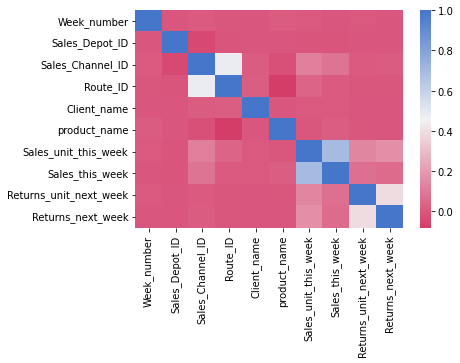

In [ ]:
cmap = sns.diverging_palette(0, 255, sep=1, n=256, as_cmap=True)

correlations = df[['Week_number', 'Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_name', 'product_name',\
                              'Sales_unit_this_week', 'Sales_this_week', 'Returns_unit_next_week', 'Returns_next_week']].corr()
print(correlations)
sns.heatmap(correlations, cmap=cmap)

From the heatmap, we see that none of the columns are highly correlated.
All the correlation values are less than 0.8.


In [ ]:
demand = df[['Sales_unit_this_week', 'Returns_unit_next_week']]

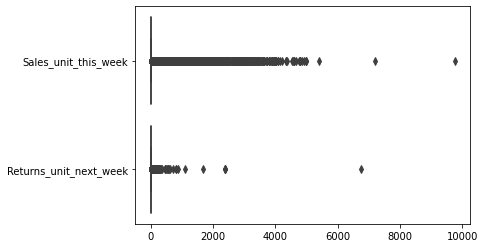

In [ ]:
sns.boxplot(data=demand , orient="h")

From the boxplot, we can infer that the Sales_unit_this_week ranges from 0 to 10000 and Returns_unit_next_week ranges from 0 to 7000 approximately.<br>
Both the attributes show some outliers in them.

In [ ]:
del demand
tf = df[['Sales_this_week', 'Returns_next_week']]

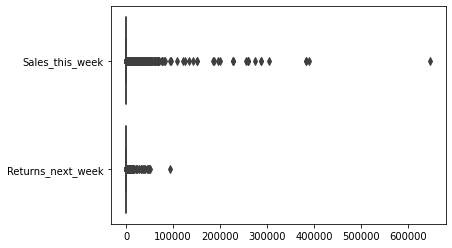

In [ ]:
sns.boxplot(data=tf , orient="h")
del tf

From the boxplot, we can infer that the Sales_this_week ranges from 0 to 700000 and Returns_unit_next_week ranges from 0 to 100000 approximately.<br>
Sales_this_week shows some outliers.

## ADDING A FEATURE FOR BETTER PREDICTION OF DEMAND.

Here we are calculating three weeks lag of sales. It describes the clients purchase history of last three weeks.

This feature can helps in clients future purchases.

As the weeks start from 3 in the dataset, considering the lag for week 5.<br>
Hence, calculating lag for weeks 3 to 5.


In [ ]:
lag3_5 = df.loc[(df['Week_number']==3) | (df['Week_number']==4),['Sales_unit_this_week','Client_name','product_name','Town']]
lag3_5=lag3_5.groupby(by=['Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_5['week']=5
lag3_5.columns=['Client_name','product_name','Town','mean_sales','Week_number']
lag3_5.shape[0]

5487745

For week 6, considering the lag for 3 weeks - 3, 4 and 5.

In [ ]:
lag3_6 = df.loc[(df['Week_number']==3) |(df['Week_number']==4) | (df['Week_number']==5),['Sales_unit_this_week','Client_name','product_name','Town']]
lag3_6=lag3_6.groupby(by=['Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_6['week']=6
lag3_6.columns=['Client_name','product_name','Town','mean_sales','Week_number']
lag3_6.shape[0]

6602773

In [ ]:
lag3_5 = pd.concat((lag3_5,lag3_6), axis=0,ignore_index=True)
lag3_5.shape

(12090518, 5)

In [ ]:
lag3_6 = df.loc[(df['Week_number']==4) |(df['Week_number']==5) | (df['Week_number']==6),['Sales_unit_this_week','Client_name','product_name','Town']]
lag3_6=lag3_6.groupby(by=['Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_6['week']=7
lag3_6.columns=['Client_name','product_name','Town','mean_sales','Week_number']
lag3_6.shape[0]

6455119

In [ ]:
lag3_5 = pd.concat((lag3_5,lag3_6), axis=0,ignore_index=True)
lag3_5.shape[0]

18545637

In [ ]:
df = df.loc[df['Week_number'] >4]
df.shape

(21442599, 13)

Joining calculated week's mean sales with original data.
Outer is used because, there may be a new client in current week, in that case his mean sales will be zero.<br>
In the same way there may be clients who has not purchased anything for current week, in that case Sales_unit_this_week, Returns_unit_next_week and Adjusted_Demand will be zero.<br>
Therefore this feature helps us to predict for such clients.

In [ ]:
df = pd.merge(lag3_5,df,how='outer',on=['Week_number','Client_name','product_name','Town'])
df.shape

(22166137, 8)

In [ ]:
df.isnull().values.any()

True

In [ ]:
df[pd.isnull(df['mean_sales']) | pd.isnull(df['Sales_unit_this_week'])].shape

(11976153, 8)

In [ ]:
df.fillna(value=0,inplace=True)
df.isnull().values.any()

False

In [ ]:
lag3_5 = df.loc[(df['Week_number']==5) | (df['Week_number']==6) | (df['Week_number']==7),['Sales_unit_this_week','Client_name','product_name','Town']]
lag3_5=lag3_5.groupby(by=['Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_5['week']=8
lag3_5.columns=['Client_name','product_name','Town','mean_sales','Week_number']
lag3_5.shape[0]

7990693

In [ ]:
train1 = df.loc[(df['Week_number']==6) |(df['Week_number']==7),['Sales_unit_this_week','Client_name','product_name','Town']]
lag3_6= test.loc[(test['Week_number']==8),['Sales_unit_this_week','Client_name','product_name','Town']]
lag3_6 = pd.concat((train1,lag3_6), axis=0,ignore_index=True)
lag3_6=lag3_6.groupby(by=['Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_6['week']=9
lag3_6.columns=['Client_name','product_name','Town','mean_sales','Week_number']
lag3_6.shape[0]

8549546

In [ ]:
lag3_6 = pd.concat((lag3_6,lag3_5), axis=0,ignore_index=True)
lag3_6.shape[0]

16540239

In [ ]:
test = pd.merge(lag3_6,test,how='outer',on=['Week_number','Client_name','product_name','Town'])
test.shape

(18255366, 8)

In [ ]:
test[pd.isnull(test['mean_sales']) | pd.isnull(test['Sales_unit_this_week'])].shape

(12183771, 10)

In [ ]:
test.fillna(value=0,inplace=True)
test.isnull().values.any()

False

READING THE GENERATED TRAIN DATASET FOR FEATURE SELECTION

In [ ]:
import pandas as pd

data=pd.read_csv("/content/drive/MyDrive/grupo-bimbo-inventory-demand/T_train.csv")

In [ ]:
data.head(2)

,Client_name,product_name,Town,mean_sales,Week_number,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Sales_unit_this_week,Sales_this_week,Returns_unit_next_week,Returns_next_week,Adjusted_Demand,State
0,250299,758,25,3.5,5,1110.0,7.0,3301.0,5.0,41.90,0.0,0.0,5.0,16.0
1,292487,758,25,2.0,5,1110.0,7.0,3301.0,2.0,16.76,0.0,0.0,2.0,16.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30748661 entries, 0 to 30748660
Data columns (total 14 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Client_name             int64  
 1   product_name            int64  
 2   Town                    int64  
 3   mean_sales              float64
 4   Week_number             int64  
 5   Sales_Depot_ID          float64
 6   Sales_Channel_ID        float64
 7   Route_ID                float64
 8   Sales_unit_this_week    float64
 9   Sales_this_week         float64
 10  Returns_unit_next_week  float64
 11  Returns_next_week       float64
 12  Adjusted_Demand         float64
 13  State                   float64
dtypes: float64(10), int64(4)
memory usage: 3.2 GB


In [ ]:
cols = ['Client_name','product_name','Town','mean_sales','Week_number','Sales_Depot_ID',\
        'Sales_Channel_ID',	'Route_ID','Sales_unit_this_week','Sales_this_week',	'Returns_unit_next_week',\
        'Returns_next_week', 'State',	'Adjusted_Demand']

In [ ]:
data = data.reindex(columns=cols)

In [ ]:
data.head()

,Client_name,product_name,Town,mean_sales,Week_number,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Sales_unit_this_week,Sales_this_week,Returns_unit_next_week,Returns_next_week,State,Adjusted_Demand
0,250299,758,25,3.5,5,1110.0,7.0,3301.0,5.0,41.90,0.0,0.0,16.0,5.0
1,292487,758,25,2.0,5,1110.0,7.0,3301.0,2.0,16.76,0.0,0.0,16.0,2.0
2,100282,758,25,2.0,5,1110.0,7.0,3301.0,2.0,16.76,0.0,0.0,16.0,2.0
3,1089,758,25,3.0,5,1110.0,7.0,3301.0,4.0,33.52,0.0,0.0,16.0,4.0
4,82835,758,25,2.5,5,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


Forming the train and test set for feature selection.

In [ ]:
array=data.values
trainerss=array[:,0:13]
testerss=array[:,13]

In [ ]:
print(trainerss)

[[2.50299e+05 7.58000e+02 2.50000e+01 ... 0.00000e+00 0.00000e+00
  1.60000e+01]
 [2.92487e+05 7.58000e+02 2.50000e+01 ... 0.00000e+00 0.00000e+00
  1.60000e+01]
 [1.00282e+05 7.58000e+02 2.50000e+01 ... 0.00000e+00 0.00000e+00
  1.60000e+01]
 ...
 [4.30370e+04 3.40000e+02 1.33000e+02 ... 4.00000e+00 9.83200e+01
  2.00000e+00]
 [4.30370e+04 3.41000e+02 1.33000e+02 ... 1.20000e+01 4.91600e+02
  2.00000e+00]
 [4.30370e+04 2.18000e+02 1.33000e+02 ... 0.00000e+00 8.40000e+00
  2.00000e+00]]


In [ ]:
print(testerss)

[5. 2. 2. ... 2. 8. 1.]


Reference for feature selection https://machinelearningmastery.com/calculate-feature-importance-with-python/

APPLYING DECISION TREE CLASSIFIER FOR THE MODELLING AND THEN FEATURE IMPORTANCE

In [ ]:
#Decision Tree Classisfier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Computing accuracy
from sklearn.metrics import accuracy_score
DTclf = DecisionTreeClassifier()
DTclf.fit(trainerss, testerss)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
from sklearn.externals import joblib
joblib.dump(DTclf, '/content/drive/MyDrive/grupo-bimbo-inventory-demand/Dtree.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['/content/drive/MyDrive/grupo-bimbo-inventory-demand/Dtree.pkl']

Checking the importance of each feature

In [ ]:
DTclf.feature_importances_

array([2.66190206e-05, 3.13967236e-05, 2.25062032e-05, 1.95671150e-05,
       1.93103032e-05, 2.70591883e-01, 8.68823618e-06, 2.72534956e-05,
       6.75324769e-01, 4.65366100e-03, 4.78726564e-02, 1.37959135e-03,
       2.20982752e-05])

In [ ]:
DTclf.feature_importances_.sum()

1.0

In [ ]:
sss = pd.Series(DTclf.feature_importances_)
sss.sort_values(ascending=False)

8     0.675325
5     0.270592
10    0.047873
9     0.004654
11    0.001380
1     0.000031
7     0.000027
0     0.000027
2     0.000023
12    0.000022
3     0.000020
4     0.000019
6     0.000009
dtype: float64

Looking at the importances, we can infer that the Sales_unit_this_week has the highest impact on the prediction of the demand.<br>
Sales_unit_this_week   : 0.675325<br>
Sales_Depot_ID         : 0.270592<br>
Returns_unit_next_week : 0.047873<br>
Sales_this_week        : 0.004654<br>
Returns_next_week.     : 0.001380<br>
product_name           : 0.000031<br>
Route_ID               : 0.000027<br>
Client_name            : 0.000027<br>
Town                   : 0.000023<br>
State                  : 0.000022
mean_sales             : 0.000020<br>
Week_number            : 0.000019<br>
Sales_Channel_ID       : 0.000009<br>

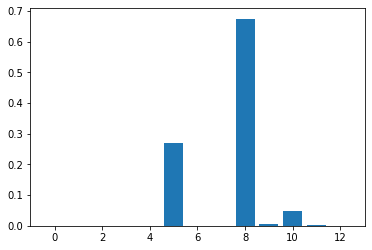

In [ ]:
import matplotlib.pyplot as plt

plt.bar([x for x in range(len(sss))], sss)
plt.show()

# LEARNING MODELS

Choice of the algorithm depends on the

-the size of the training data

-the number of features

-the quality of the features

Select data 8-9 week as test data

In [ ]:
import random
n=22166137
s=15000000
skip = sorted(random.sample(range(1,n),n-s))
df = pd.read_csv('T_train.csv', skiprows=skip,header=0)

n=18255366
s=5000000
skip = sorted(random.sample(range(1,n),n-s))
test = pd.read_csv('T_test.csv',skiprows=skip,header=0)

In [ ]:
df = pd.concat((df,test), axis=0,ignore_index=True)

In [ ]:
test= df['Adjusted_Demand']
df = df.drop('Adjusted_Demand',axis=1)

In [ ]:
from sklearn import cross_validation
## Spliting of training dataset into 70% training data and 30% testing data randomly
x_train, x_test, y_train, y_test = cross_validation.train_test_split(df, test, test_size=0.3, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


    Model Evaluation in four different categories:

    1. Underfitting – Validation and training error high
    2. Overfitting – Validation error is high, training error low
    3. Good fit – Validation error low, slightly higher than the training error
    4. Unknown fit - Validation error low, training error 'high'

## Multiple linear regression model

In [ ]:
from sklearn import linear_model
from sklearn.metrics import r2_score

In [ ]:
norm='False'
inter='False'

trm=[]
tarm=[]
rs=[]
nm=[]
it=[]
   
clf = linear_model.LinearRegression(n_jobs=4,normalize=norm,fit_intercept=inter)
clf.fit(x_train, y_train)

prediction = clf.predict(x_test).astype(int)
r =math.sqrt(np.mean((prediction - y_test) ** 2))
r2 =r2_score(y_test,prediction)       

prediction1 = clf.predict(x_train).astype(int)
r1 =math.sqrt(np.mean((prediction1 - y_train) ** 2))

print("Normalize: ",norm," Fit_intercept: ",inter,"  train_RMSE: %.3f" % r1,"  test_RMSE: %.3f" % r,"  R_square: ",r2)
print()

trm.append(r)
tarm.append(r1)
rs.append(r2)
nm.append(norm)
it.append(inter)

res=pd.DataFrame()
res['normalize']=nm
res['fit_intercept']=it
res['test_rmse']=trm
res['train_rmse']=tarm
res['r_square']=rs

res.to_csv('lm.csv', mode='a', header=False,index=False)
del res

Normalize:  False  Fit_intercept:  False   train_RMSE: 0.377   test_RMSE: 0.377   R_square:  0.999520255096



In [ ]:
linear_model=pd.read_csv('lm.csv',header=0,index_col=None)
linear_model.head()

,normalize,fit_intercept,test_rmse,train_rmse,r_square
0,False,True,0.551745,0.546625,0.998885
1,False,False,0.551745,0.546625,0.998885
2,True,True,0.551745,0.546625,0.998885
3,True,False,0.551745,0.546625,0.998885


In [ ]:
linear_model.drop('r_square',axis=1,inplace=True)
linear_model.set_index(['normalize','fit_intercept'],inplace=True)
linear_model.head()

test_rmse  train_rmse
normalize fit_intercept                       
False     True            0.551745    0.546625
          False           0.551745    0.546625
True      True            0.551745    0.546625
          False           0.551745    0.546625

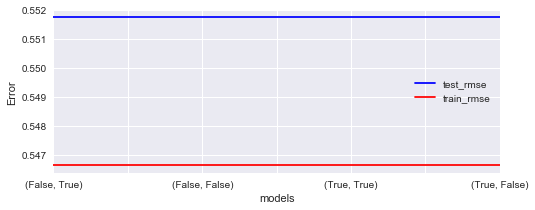

In [ ]:
linear_model.plot(kind='line', color=['blue','red'], rot=0,figsize=(8,3))
plt.xlabel('models')
plt.ylabel('Error')
sns.despine()

From graph we see that test_rmse is slightly greater than train_rmase, indicating that linear model is making good fit.

## Ridge Regression

Ridge model uses regulization function to avoid overfitting or underfitting which may occur in normal linear regression.

Regularization is a process of introducing additional information in order to solve an ill-posed problem or to prevent overfitting.

It uses L2 regulization.

y = argmin ||Y-Xβ||^2 + λ||β||^2

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

In [ ]:
alp=1.5
norm='False'
inter='True'

trm=[]
tarm=[]
rs=[]
nm=[]
it=[]
alpha=[]

rdg = Ridge(alpha=alp,solver=sol,normalize=norm,fit_intercept=inter)
rdg.fit(x_train, y_train)

prediction = rdg.predict(x_test).astype(int)
r =math.sqrt(np.mean((prediction - y_test) ** 2))
r2=r2_score(y_test,prediction)

prediction1 = rdg.predict(x_train).astype(int)
r1 =math.sqrt(np.mean((prediction1 - y_train) ** 2))

print("Normalize: ",norm," Fit_intercept: ",inter,"  train_RMSE: %.3f" % r1,"  test_RMSE: %.3f" % r," R_squar: ",r2)
print()

trm.append(r)
tarm.append(r1)
rs.append(r2)
nm.append(norm)
it.append(inter)
alpha.append(alp)

res=pd.DataFrame()
res['alpha']=alpha
res['normalize']=nm
res['fit_intercept']=it
res['test_rmse']=trm
res['train_rmse']=tarm
res['r_square']=rs

res.to_csv('ridge.csv', mode='a', header=False,index=False)
del res

Normalize:  False  Fit_intercept:  True   train_RMSE: 9.307   test_RMSE: 9.393  R_squar:  0.702822216432



In [ ]:
ridge_model=pd.read_csv('ridge.csv',header=0,index_col=None)
ridge_model.drop('r_square',axis=1,inplace=True)
ridge_model['model_id']=ridge_model.index
ridge_model.head()

,alpha,normalize,fit_intercept,test_rmse,train_rmse,model_id
0,1.0,False,True,7.967714,7.828250,0
1,1.0,False,False,7.967714,7.828250,1
2,1.0,True,True,7.967714,7.828250,2
3,1.0,True,False,7.967714,7.828250,3
4,0.5,False,True,5.773437,5.592188,4


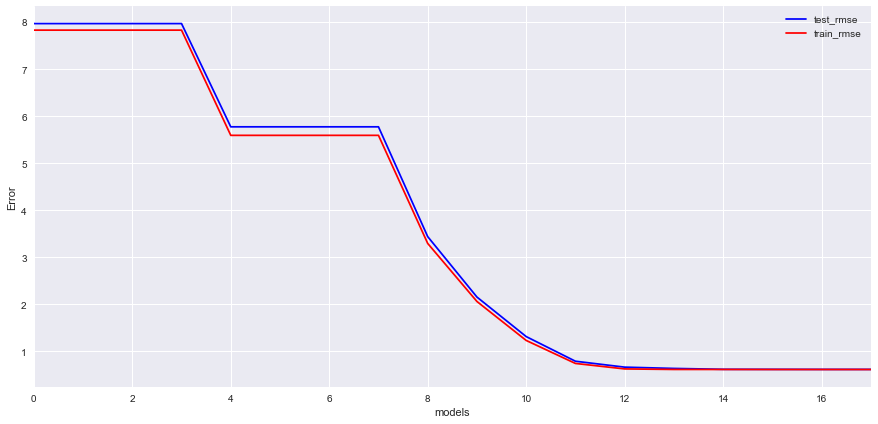

In [ ]:
model=ridge_model.drop(['alpha','normalize','fit_intercept'],axis=1)
model.set_index(['model_id'],inplace=True)
model.plot(kind='line', color=['blue','red'], rot=0,figsize=(15,7))
plt.xlabel('models')
plt.ylabel('Error')
sns.despine()

    Here we see that from 12th model onwards training and validation error are alomost same.
    Here validation error is low but not very high difference between the train and validation errors.
    So we going to select 12 model, since validation error is slightly greater than training error.

In [ ]:
ridge_model.loc[ridge_model['model_id']==12]

,alpha,normalize,fit_intercept,test_rmse,train_rmse,model_id
12,0.01,False,True,0.665761,0.628308,12


## Lasso Regression

Similar to Ridge Regression, Lasso also penalizes the absolute size of the regression coefficients. In addition, it is capable of reducing the variability and improving the accuracy of linear regression models.

y = argmin ||Y-Xβ||^2 + λ||β||

Lasso regression differs from ridge regression in a way that it uses absolute values in the penalty function, instead of squares. This leads to penalizing values which causes some of the parameter estimates to turn out exactly zero. 

It uses L1 regulization.

In [ ]:
df = pd.read_csv('T_train.csv', header=0)
test = pd.read_csv('T_test.csv',header=0)

In [ ]:
y_train= df['Adjusted_Demand']
x_train = df.drop('Adjusted_Demand',axis=1)
y_test= test['Adjusted_Demand']
x_test = test.drop('Adjusted_Demand',axis=1)

In [ ]:
from sklearn import linear_model
from sklearn.metrics import r2_score

In [ ]:
def lassomodel(x_train, x_test, y_train, y_test):
   # f=0.3
    alp=0.0
    #train1 =df.sample(frac=f)
    #y_train = train1['Adjusted_Demand']
    #x_train = train1.drop('Adjusted_Demand',axis=1)
    res=pd.DataFrame()
    res['alpha']= ['alpha']
    res['rmse_train']=['rmse_train']
    res['r_square_train']=['r_square_train']
    res['rmse_test']=['rmse_test']
    res['r_square_test']=['r_square_test']
    res.to_csv('lasso_model.csv',header=False,index=False)
    
    for x in range(10):
        alp=alp+0.05
        s=[]
        rm=[]
        rs=[]
        rm2=[]
        rs2=[]
        al=[]
        res=pd.DataFrame()
        
        clf = linear_model.Lasso(alpha=alp)
        clf.fit(x_train, y_train)
        prediction = clf.predict(x_train).astype(int)
        
        r =math.sqrt(np.mean((prediction - y_train) ** 2))
        r2=r2_score(y_train,prediction)
        
        prediction2 = clf.predict(x_test).astype(int)
        
        rr2 =math.sqrt(np.mean((prediction2 - y_test) ** 2))
        r22=r2_score(y_test,prediction2)
        
        
        rm.append(r)
        rs.append(r2)
        rm2.append(rr2)
        rs2.append(r22)
        al.append(alp)
        print("------------------------------------------------------------------\n")
        print("For ALPHA value:",alp,"  RMSE: %.3f" % r," R_square: ",r2,)
        print("\n")
        print("For ALPHA value:",alp,"  RMSE: %.3f" % rr2," R_square: ",r22,)
        print("------------------------------------------------------------------\n")
        res['alpha']= al
        res['rmse_train']=rm
        res['r_square_train']=rs
        res['rmse_test']=rm2
        res['r_square_test']=rs2
        res.to_csv('lasso_model.csv', mode='a', header=False,index=False)
        del res,s,rm,rs

In [ ]:
lassomodel(x_train, x_test, y_train, y_test)

------------------------------------------------------------------

For ALPHA value: 0.05   RMSE: 0.751  R_square:  0.998189174066


For ALPHA value: 0.05   RMSE: 0.683  R_square:  0.998247771868
------------------------------------------------------------------

------------------------------------------------------------------

For ALPHA value: 0.1   RMSE: 0.756  R_square:  0.998166685325


For ALPHA value: 0.1   RMSE: 0.710  R_square:  0.998109985268
------------------------------------------------------------------

------------------------------------------------------------------

For ALPHA value: 0.15000000000000002   RMSE: 0.764  R_square:  0.998126673692


For ALPHA value: 0.15000000000000002   RMSE: 0.752  R_square:  0.997877489896
------------------------------------------------------------------

------------------------------------------------------------------

For ALPHA value: 0.2   RMSE: 0.776  R_square:  0.998066684233


For ALPHA value: 0.2   RMSE: 0.808  R_square:  0

In [ ]:
r=pd.read_csv('lasso_model.csv',header=0)
r.head()

,alpha,rmse_train,r_square_train,rmse_test,r_square_test
0,0.05,0.751497,0.998189,0.683364,0.998248
1,0.10,0.756149,0.998167,0.709724,0.998110
2,0.15,0.764356,0.998127,0.752111,0.997877
3,0.20,0.776498,0.998067,0.808328,0.997548
4,0.25,0.791739,0.997990,0.875209,0.997126


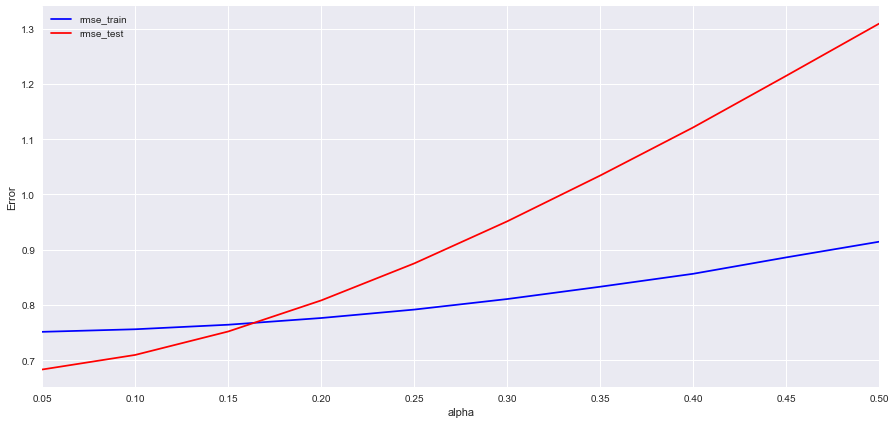

In [ ]:
model=r.drop(['r_square_train','r_square_test'],axis=1)
model.set_index(['alpha'],inplace=True)
model.plot(kind='line', color=['blue','red'], rot=0,figsize=(15,7))
plt.xlabel('alpha')
plt.ylabel('Error')
sns.despine()

    For Alpha= 0.1 we have less validation and training error,but it is making unkonwn fit.
    At alpha =0.2 validation error is slightly greater than train error, So we select model with alpha=0.2.

In [ ]:
r.loc[r['alpha']==0.2]

,alpha,rmse_train,r_square_train,rmse_test,r_square_test
3,0.2,0.776498,0.998067,0.808328,0.997548


In [ ]:
def l2(x_test,y_test,df):
    f=0.4
    for x in range(2):   
        s=[]
        rm=[]
        rs=[]
        al=[]
        res=pd.DataFrame()
        train1 =df.sample(frac=f)
        y_train = train1['Adjusted_Demand']
        x_train = train1.drop('Adjusted_Demand',axis=1)
        
        clf = linear_model.Lasso(alpha=0.2)
        clf.fit(x_train, y_train)
        prediction = clf.predict(x_test).astype(int)
        
        r =math.sqrt(np.mean((prediction - y_test) ** 2))
        r2=r2_score(y_test,prediction)
        
        v = int(f*100)
        s.append(v)
        rm.append(r)
        rs.append(r2)
        al.append(0.2)
        print("For Sample:",v,"%%  RMSE: %.3f" % r," R_square: ",r2)
        print()
        f=f+0.1
        res['size']=s
        res['rmse']=rm
        res['r_square']=rs
        res['alpha']= al
        res.to_csv('lasso2.csv', mode='a', header=False,index=False)
        del res,s,rm,rs

In [ ]:
 l2(x_test,y_test,df)

For Sample: 40 %  RMSE: 0.747  R_square:  0.997908838189

For Sample: 50 %  RMSE: 0.769  R_square:  0.997783532369



## ElasticNet Regression

ElasticNet is hybrid of Lasso and Ridge Regression techniques. It is trained with L1 and L2 prior as regularizer. Elastic-net is useful when there are multiple features which are correlated.

Y= armin( ||y-xβ||^2 + λ2||β2||^2 + λ1||β1|| ).

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

In [ ]:
sam1 =df.sample(frac=0.7)
y_train = sam1['Adjusted_Demand']
x_train = sam1.drop('Adjusted_Demand',axis=1)
y_test = test['Adjusted_Demand']
x_test = test.drop('Adjusted_Demand',axis=1)

Default value of l1_ratio is 0.5 and alpha is 1.0 

In [ ]:
l1_ratio=[]
alpha =[]
ValidError =[]

def elasticErrors(x_train,y_train,x_test,y_test):
    f=0.8
    i=0
    l1=0.5
    for y in range(6):
        i=i+1
        f=0.9
        print("For l1_ratio=", l1)
        for x in range(8):
            sol=[]
            res=pd.DataFrame()
            regr = ElasticNet(alpha=f,l1_ratio=l1,random_state=0)
            regr.fit(x_train, y_train)
            prediction = regr.predict(x_train).astype(int)
            r =math.sqrt(np.mean((prediction - y_train) ** 2))
            #r2=r2_score(y_train,prediction)
            l1_ratio.append(l1)
            alpha.append(f)
            ValidError.append(r)
            #print("Done with alpha", f)
            f=f-0.1
        if i==5:
            l1=0.05
        else:
            l1=l1-0.1
        

In [ ]:
elasticErrors(x_train,y_train,x_test,y_test)

For l1_ratio= 0.5
For l1_ratio= 0.4
For l1_ratio= 0.30000000000000004
For l1_ratio= 0.20000000000000004
For l1_ratio= 0.10000000000000003
For l1_ratio= 0.05


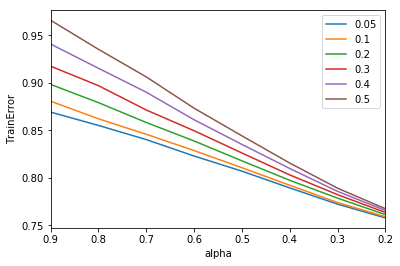

In [ ]:
Elastic_err=pd.DataFrame(columns=['l1_ratio','alpha','ValidError'])
Elastic_err['l1_ratio'] = l1_ratio
Elastic_err['alpha'] = alpha
Elastic_err['ValidError'] = ValidError
#Elastic_err
fig, ax = plt.subplots()
labels = []
for key, grp in Elastic_err.groupby(['l1_ratio']):
    ax = grp.plot(ax=ax, kind='line', x='alpha', y='ValidError')
    labels.append(key)
lines,_= ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.ylabel('TrainError')
plt.show()

The above graph shows the variation in train error with changing l1_ratios for different alphas. 
l1_ratio=0.05 is giving the least error.

Now for l1_ratio is kept constant(0.05) and alpha decreased to compare validation and train error

In [ ]:
alpha=[]
TrainError=[]
ValidError=[]

def elasticErrors(x_train,y_train,x_test,y_test):
    f=0.9
    i=0
    for x in range(9):
        i=i+1
        sol=[]
        res=pd.DataFrame()
        regr = ElasticNet(alpha=f,l1_ratio=0.05,random_state=0)
        regr.fit(x_train, y_train)
        pred_train = regr.predict(x_train).astype(int)
        r_train =math.sqrt(np.mean((pred_train - y_train) ** 2))
        pred_test = regr.predict(x_test).astype(int)
        r_test =math.sqrt(np.mean((pred_test - y_test) ** 2))
        #r2=r2_score(y_train,prediction)
        alpha.append(f)
        TrainError.append(r_train)
        ValidError.append(r_test)
        print("Done with alpha", f)
        f=f-0.1
        

In [ ]:
elasticErrors(x_train,y_train,x_test,y_test)

Done with alpha 0.9
Done with alpha 0.8
Done with alpha 0.7000000000000001
Done with alpha 0.6000000000000001
Done with alpha 0.5000000000000001
Done with alpha 0.40000000000000013
Done with alpha 0.30000000000000016
Done with alpha 0.20000000000000015
Done with alpha 0.10000000000000014


In [ ]:
Elastic_err=pd.DataFrame(columns=['alpha','TrainError','ValidError'])
Elastic_err['alpha'] = alpha
Elastic_err['TrainError'] = TrainError
Elastic_err['ValidError'] = ValidError
#model_score.set_index("l1_ratio",inplace=True)
Elastic_err

,alpha,TrainError,ValidError
0,0.9,0.867481,1.158263
1,0.8,0.853797,1.111788
2,0.7,0.838757,1.060606
3,0.6,0.821483,1.003799
4,0.5,0.805042,0.943309
5,0.4,0.787070,0.877903
6,0.3,0.770627,0.810692
7,0.2,0.755996,0.745395
8,0.1,0.745301,0.691794


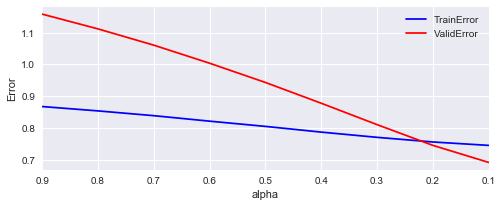

In [ ]:
Elastic_err.set_index(['alpha'],inplace=True)
Elastic_err.plot(kind='line', color=['blue','red'], rot=0,figsize=(8,3))
plt.xlabel('alpha')
plt.ylabel('Error')
sns.despine()

l1_ratio=0.05 and alpha=0.3 gives the least error

In [ ]:
sample=[]
ValidError=[]

def elasticSamples(df):
    sam=0.1
    for x in range(6):
        res=pd.DataFrame()
        train1 =df.sample(frac=sam)
        y_train = train1['Adjusted_Demand']
        x_train = train1.drop('Adjusted_Demand',axis=1)
        regr = ElasticNet(alpha=0.35,l1_ratio=0.05,random_state=0)
        regr.fit(x_train, y_train)
        prediction = regr.predict(x_test).astype(int)
        r =math.sqrt(np.mean((prediction - y_test) ** 2))
        #r2=r2_score(y_train,prediction)
        per=sam*100
        sample.append(per)
        ValidError.append(r)
        #r_sq.append(r2)
        #f=f+0.2
        print("Done for sample", per)
        sam=sam+0.1
        
        

In [ ]:
elasticSamples(df)

Done for sample 10.0
Done for sample 20.0
Done for sample 30.000000000000004
Done for sample 40.0
Done for sample 50.0
Done for sample 60.0


In [ ]:
ElasticSam=pd.DataFrame(columns=['sample','ValidError'])
ElasticSam['sample'] = sample
ElasticSam['ValidError'] = ValidError
#model_score.set_index("l1_ratio",inplace=True)
ElasticSam

,sample,ValidError
0,10.0,1.003399
1,20.0,0.883382
2,30.0,0.892672
3,40.0,0.900006
4,50.0,0.881486
5,60.0,0.847162


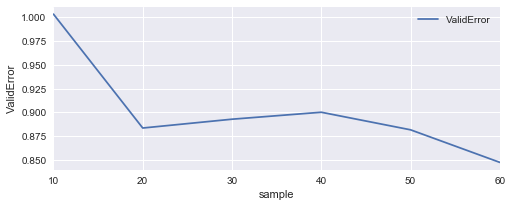

In [ ]:
ElasticSam.set_index(['sample'],inplace=True)
ElasticSam.plot(kind='line', rot=0,figsize=(8,3))
plt.xlabel('sample')
plt.ylabel('ValidError')
sns.despine()

## Robust linear model estimation using RANSAC algorithm

Certain widely used methods of regression, such as ordinary least squares, have favourable properties if their underlying assumptions are true, but can give misleading results if those assumptions are not true; thus ordinary least squares is said to be not robust to violations of its assumptions. Robust regression methods are designed to be not overly affected by violations of assumptions by the underlying data-generating process.

RANSAC is an iterative method to estimate parameters of a mathematical model from a set of observed data that contains outliers.

In [ ]:
from sklearn import linear_model

In [ ]:
ransac = linear_model.RANSACRegressor(residual_threshold =1)
ransac.fit(x_train, y_train)
prediction = ransac.predict(x_test).astype(int)

prediction1 = ransac.predict(x_train).astype(int)

In [ ]:
r =math.sqrt(np.mean((prediction - y_test) ** 2))
r1 =math.sqrt(np.mean((prediction1 - y_train) ** 2))
#r = np.sqrt(np.square(np.log(prediction + 1) - np.log(y_test + 1)).mean())
print("test_RMSE: %.3f" % r," Train_RMSE: %.3f" % r1)

test_RMSE: 0.563  Train_RMSE: 0.640


In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test,prediction)

model.append("Robust model")
rmse.append(r)
r_sqr.append(r2)

    Models                              Validation Error
    
    Multiple linear regression          0.551745
    Ridge Regression                    0.665761
    Lasso Regression                    0.804342

In [ ]:
import random
from sklearn import cross_validation
from sklearn import linear_model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
def LM():
    f =[0.65]
    
    for x in f:
        print('start')
        n=22166137
        s=int(n*x)
        skip = sorted(random.sample(range(1,n),n-s))
        df = pd.read_csv('T_train.csv', skiprows=skip,header=0)
        n=18255366
        s=int(n*x)
        skip = sorted(random.sample(range(1,n),n-s))
        test = pd.read_csv('T_test.csv',skiprows=skip,header=0)

        df = pd.concat((df,test), axis=0,ignore_index=True)
        
        test= df['Adjusted_Demand']
        df = df.drop('Adjusted_Demand',axis=1)

        x_train, x_test, y_train, y_test = cross_validation.train_test_split(df, test, test_size=0.3, random_state=42)
        
        trm=[]
        tarm=[]
        sp=[]
        
        clf = linear_model.LinearRegression(n_jobs=4)
        clf.fit(x_train, y_train)
        print('1')
        prediction = clf.predict(x_test).astype(int)
        r =math.sqrt(np.mean((prediction - y_test) ** 2))      

        prediction1 = clf.predict(x_train).astype(int)
        r1 =math.sqrt(np.mean((prediction1 - y_train) ** 2))

        print("train_RMSE: %.3f" % r1,"  test_RMSE: %.3f" % r)
        print()
        trm.append(r)
        tarm.append(r1)
        sp.append(int(x*100))

        res=pd.DataFrame()
        res['test_rmse']=trm
        res['train_rmse']=tarm
        res['sample']=sp

        res.to_csv('linear.csv', mode='a', header=False,index=False)
        del res

In [ ]:
LM()

In [ ]:
m=pd.read_csv('linear.csv',header=0)
m.head()

,test_rmse,train_rmse,sample
0,0.524441,0.524949,10
1,0.563938,0.563529,15
2,0.364069,0.364287,20
3,0.412309,0.411825,25
4,0.490285,0.490262,30


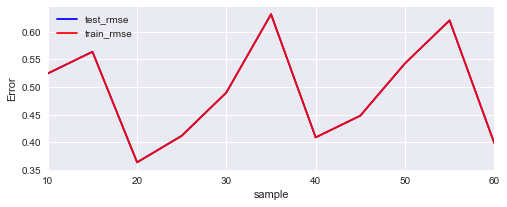

In [ ]:
m.set_index('sample',inplace=True)
m.plot(kind='line', color=['blue','red'], rot=0,figsize=(8,3))
plt.xlabel('sample')
plt.ylabel('Error')
sns.despine()

# Post-processing

In [ ]:
def ReadTrain(df):
    s=0
    n=10000000
    for x in range(7):
        if x == 0:
            print('Reading ',s,' to ',n+s)
            train1 = pd.read_csv('train.csv',nrows=n,header = 0,index_col=None,usecols=[0,1,2,3,4,5,6,8,10],
                    dtype={'Semana':np.uint8,'Agencia_ID':np.uint16,'Canal_ID':np.uint8,'Ruta_SAK':np.uint16,
                           'Cliente_ID':np.uint16,'Producto_ID':np.uint16,'Venta_uni_hoy':np.uint32,
                           'Dev_uni_proxima':np.uint32,'Demanda_uni_equil':np.uint32})

            train1.columns =['Week_number','Sales_Depot_ID','Sales_Channel_ID','Route_ID','Client_ID','Product_ID',\
                             'Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand']
            train1.head()
        elif x < 6:
            print('Reading ',s,' to ',n+s)
            train1 = pd.read_csv('train.csv',skiprows=range(1,s+1),nrows=n,header = 0,index_col=None,usecols=[0,1,2,3,4,5,6,8,10],
                    dtype={'Semana':np.uint8,'Agencia_ID':np.uint16,'Canal_ID':np.uint8,'Ruta_SAK':np.uint16,
                           'Cliente_ID':np.uint16,'Producto_ID':np.uint16,'Venta_uni_hoy':np.uint32,
                           'Dev_uni_proxima':np.uint32,'Demanda_uni_equil':np.uint32})

            train1.columns =['Week_number','Sales_Depot_ID','Sales_Channel_ID','Route_ID','Client_ID','Product_ID',\
                             'Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand']
            train1.head()
        else:
            print('Reading remaining values')
            train1 = pd.read_csv('train.csv',skiprows=range(1,s+1),header = 0,index_col=None,usecols=[0,1,2,3,4,5,6,8,10],
                    dtype={'Semana':np.uint8,'Agencia_ID':np.uint16,'Canal_ID':np.uint8,'Ruta_SAK':np.uint16,
                           'Cliente_ID':np.uint16,'Producto_ID':np.uint16,'Venta_uni_hoy':np.uint32,
                           'Dev_uni_proxima':np.uint32,'Demanda_uni_equil':np.uint32})

            train1.columns =['Week_number','Sales_Depot_ID','Sales_Channel_ID','Route_ID','Client_ID','Product_ID',\
                             'Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand']
            train1.head()
        s=s+n
        print('Checking for null values')
        print('Number before droping Nan values:',train1.shape[0])
        train1.dropna(axis=0,how='any',subset=['Week_number','Sales_Depot_ID','Sales_Channel_ID','Route_ID','Client_ID','Product_ID'])
        print('Number after droping Nan values:',train1.shape[0])
        
        print('Checking for duplicate values')
        print('Number before droping duplicate values:',train1.shape[0])
        orginal = train1.shape[0]
        train1.drop_duplicates(subset=['Week_number','Sales_Depot_ID','Sales_Channel_ID','Route_ID','Client_ID','Product_ID','Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand'],keep='first', inplace=True)
        print('Number after droping duplicate values:',train1.shape[0])
        duplicate = orginal-train1.shape[0]
        percentage = (duplicate/orginal)*100
        print("Duplicate values percentage: %.3f%%" % percentage)
        
        print('Number values where returns are more than sales:',train1.loc[train1['Returns_unit_next_week'] > train1['Sales_unit_this_week']].shape[0])
        train1.loc[train1['Returns_unit_next_week'] > train1['Sales_unit_this_week'],['Sales_unit_this_week', 'Returns_unit_next_week']]= \
        train1.loc[train1['Returns_unit_next_week'] > train1['Sales_unit_this_week'],['Returns_unit_next_week','Sales_unit_this_week']].values

        print('Number values where adjusted values are zero:',train1['Adjusted_Demand'].loc[train1['Adjusted_Demand'] ==0].count())
        train1['Diff']=train1['Sales_unit_this_week']-train1['Returns_unit_next_week']
        train1.loc[(train1['Adjusted_Demand'] == 0) & (train1['Sales_unit_this_week'] != train1['Returns_unit_next_week']),['Adjusted_Demand','Diff']] = \
        train1.loc[(train1['Adjusted_Demand'] == 0) & (train1['Sales_unit_this_week'] != train1['Returns_unit_next_week']),['Diff','Adjusted_Demand']].values
        train1.drop(['Diff'],axis=1,inplace=True)
        
        print('Joining all the dataset:')
        print('Joining client dataset:')
        train1 =pd.merge(train1,client,how='inner',on='Client_ID')
        train1.drop(['Client_ID','name'],axis=1,inplace=True)
        print('Joining Town-state dataset:')
        train1 =pd.merge(train1,town,how='inner',on='Sales_Depot_ID')
        train1.drop(['Sales_Depot_ID','State','Town_name'],axis=1,inplace=True)
        print('Joining Product dataset:')
        train1 =pd.merge(train1,product,how='inner',on='Product_ID') 
        train1.drop(['Product_ID','product','brand','weight','pieces'],axis=1,inplace=True)
        
        if x == 0:
            df = train1
        else:
            df = pd.concat((df,train1), axis=0,ignore_index=True)
        print('Shape: ',df.shape,'\n')
    return df

In [ ]:
df = pd.DataFrame(columns=['Week_number','Sales_Depot_ID','Sales_Channel_ID','Route_ID','Client_ID','Product_ID',\
                             'Sales_unit_this_week','Returns_unit_next_week','Adjusted_Demand'])
print('Reading Training data')
df = ReadTrain(df)
print('Reading Training data completed')
df.head()

Reading Training data
Reading  0  to  10000000
Checking for null values
Number before droping Nan values: 10000000
Number after droping Nan values: 10000000
Checking for duplicate values
Number before droping duplicate values: 10000000
Number after droping duplicate values: 9999551
Duplicate values percentage: 0.004%
Number values where returns are more than sales: 75247
Number values where adjusted values are zero: 163223
Joining all the dataset:
Joining client dataset:
Joining Town-state dataset:
Joining Product dataset:
Shape:  (4117204, 9) 

Reading  10000000  to  20000000
Checking for null values
Number before droping Nan values: 10000000
Number after droping Nan values: 10000000
Checking for duplicate values
Number before droping duplicate values: 10000000
Number after droping duplicate values: 9999571
Duplicate values percentage: 0.004%
Number values where returns are more than sales: 75508
Number values where adjusted values are zero: 162562
Joining all the dataset:
Joining cli

,Week_number,Sales_Channel_ID,Route_ID,Sales_unit_this_week,Returns_unit_next_week,Adjusted_Demand,Client_name,Town,product_name
0,3,7,3301,3,0,3,250299,25,758
1,3,7,3301,2,0,2,292487,25,758
2,3,7,3301,2,0,2,100281,25,758
3,3,7,3301,4,0,4,1088,25,758
4,3,7,3301,1,0,1,82834,25,758


In [ ]:
test = df.loc[df['Week_number']>7]
test.shape

(8591769, 9)

In [ ]:
lag3_5 = df.loc[(df['Week_number']==3) | (df['Week_number']==4),['Sales_unit_this_week','Sales_Channel_ID','Route_ID','Client_name','product_name','Town']]
lag3_5=lag3_5.groupby(by=['Sales_Channel_ID','Route_ID','Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_5['week']=5
lag3_5.columns=['Sales_Channel_ID','Route_ID','Client_name','product_name','Town','mean_sales','Week_number']

lag3_6 = df.loc[(df['Week_number']==3) |(df['Week_number']==4) | (df['Week_number']==5),['Sales_unit_this_week','Sales_Channel_ID','Route_ID','Client_name','product_name','Town']]
lag3_6=lag3_6.groupby(by=['Sales_Channel_ID','Route_ID','Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_6['week']=6
lag3_6.columns=['Sales_Channel_ID','Route_ID','Client_name','product_name','Town','mean_sales','Week_number']

lag3_5 = pd.concat((lag3_5,lag3_6), axis=0,ignore_index=True)
del lag3_6
lag3_5.shape[0]

12830017

In [ ]:
lag3_6 = df.loc[(df['Week_number']==4) |(df['Week_number']==5) | (df['Week_number']==6),['Sales_unit_this_week','Sales_Channel_ID','Route_ID','Client_name','product_name','Town']]
lag3_6=lag3_6.groupby(by=['Sales_Channel_ID','Route_ID','Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_6['week']=7
lag3_6.columns=['Sales_Channel_ID','Route_ID','Client_name','product_name','Town','mean_sales','Week_number']

lag3_5 = pd.concat((lag3_5,lag3_6), axis=0,ignore_index=True)
df = df.loc[(df['Week_number'] >4) & (df['Week_number'] < 8)]

df = pd.merge(lag3_5,df,how='outer',on=['Week_number','Sales_Channel_ID','Route_ID','Client_name','product_name','Town'])
df.fillna(value=0,inplace=True)
del lag3_5,lag3_6
df.shape

(31742234, 10)

In [ ]:
df.to_csv('Post_train.csv',header=True,index=False)

In [ ]:
lag3_5 = df.loc[(df['Week_number']==5) | (df['Week_number']==6) | (df['Week_number']==7),['Sales_unit_this_week','Sales_Channel_ID','Route_ID','Client_name','product_name','Town']]
lag3_5=lag3_5.groupby(by=['Sales_Channel_ID','Route_ID','Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_5['week']=8
lag3_5.columns=['Sales_Channel_ID','Route_ID','Client_name','product_name','Town','mean_sales','Week_number']

In [ ]:
train1 = df.loc[(df['Week_number']==6) |(df['Week_number']==7),['Sales_unit_this_week','Sales_Channel_ID','Route_ID','Client_name','product_name','Town']]
lag3_6= test.loc[(test['Week_number']==8),['Sales_unit_this_week','Sales_Channel_ID','Route_ID','Client_name','product_name','Town']]
lag3_6 = pd.concat((train1,lag3_6), axis=0,ignore_index=True)
lag3_6=lag3_6.groupby(by=['Sales_Channel_ID','Route_ID','Client_name','product_name','Town'],as_index=False,sort=False).aggregate(np.mean)
lag3_6['week']=9
lag3_6.columns=['Sales_Channel_ID','Route_ID','Client_name','product_name','Town','mean_sales','Week_number']

In [ ]:
lag3_6 = pd.concat((lag3_6,lag3_5), axis=0,ignore_index=True)
test = pd.merge(lag3_6,test,how='outer',on=['Week_number','Sales_Channel_ID','Route_ID','Client_name','product_name','Town'])
test.fillna(value=0,inplace=True)
test.shape

(15638521, 10)

In [ ]:
test.to_csv('Post_test.csv',header=True,index=False)

**Conclusion**

After plotting the feature importances, we can infer that there are three predictors impacting the prediction namely Sales_unit_this_week, Sales_Depot_ID and Returns_unit_next_week. Wen can consider these three features for modeling and testing on the test dataset.

* Which independent variables are useful to predict a target (dependent variable)?<br>
Sales_unit_this_week, Sales_Depot_ID, Returns_unit_next_week<br>

* Which independent variables have missing data? How much? <br>
No independent variables have missing data.<br>

* Do the training and test sets have the same data?<br>
Yes, train and test sets have the same data.<br>

* In the predictor variables independent of all the other predictor variables?<br>
Yes, all perdictor variables are independent.<br>

* Which predictor variables are the most important?<br>
Sales_unit_this_week is the most important feature.<br>